# Import Libraries 

In [121]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import golden
from scipy.optimize import fminbound
from scipy.linalg import svd
from scipy.stats import trim_mean
import scipy.io
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm

# Options

In [1]:
normalize_data = True
random_start = False
full_plot = False
first_half = True

# Initialize Parameters & Load Data

In [123]:
#Phased is a matrix of 64 TI trials. Each TI trial has 100 noise realizations with 2048 echos

file_oi = "real_phased_dataset"

raw = scipy.io.loadmat('C:\\co\\NIA\\Stabilization\\Data\\' + file_oi+ '.mat')
raw_data = raw[file_oi]

with open('C:\\co\\NIA\\Stabilization\\Data\\TI_phantom_nullExp.txt') as f:
    TI = f.readlines()

TI_num = [sub.replace("\n", "") for sub in TI]
TI_array = [1000*float(elem) for elem in TI_num]#sec/ms conversion
assert(TI_array[0] < TI_array[-1])

noise_realizations = raw_data.shape[-1]
assert(len(TI_array) == raw_data.shape[1])

TE_sequence = np.arange(1,2048.1,1)*0.4 #ms

if first_half:
    cut_point = int(2048/2)
    TE_sequence = TE_sequence[:cut_point]
    raw_data = raw_data[:cut_point,:,:]

print(raw_data.shape)

#Upper will be referred to as the second point
T2up = 39.4 #39.4 +- 0.2 ms
T1up = 317 #317 +- 9 ms

#Upper will be referred to as the first point
T2low = 31.3 #39.4 +- 0.1 ms
T1low = 103.6 #317 +- 4 ms

#### Nullpoint Values
TI1star = np.log(2)*T1low
TI2star = np.log(2)*T1up

if random_start:
    num_starts = 10
else:
    num_starts = 1

#This is important as it is used as the maximum magnitude that d1 and d2 are allowed to be 
if normalize_data:
    max_sig_mag = 1
else:
    max_sig_mag = np.max(np.abs(raw_data))

(1024, 64, 99)


# Define Functions

In [124]:
def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def S_biX_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

def get_func_bounds(function):
    f_name = function.__name__
    if f_name == "S_biX_4p":
        lower_bound = (-1*max_sig_mag,-1*max_sig_mag,0,0)
        upper_bound = (1*max_sig_mag,1*max_sig_mag,100,600)
    elif f_name == "S_moX_2p":
        lower_bound = (-1*max_sig_mag,0)
        upper_bound = (1*max_sig_mag,300)
    else:
        raise Exception("Not a valid function: " + f_name)

    return lower_bound, upper_bound

def get_param_list(function):
    f_name = function.__name__
    if f_name == "S_biX_4p":
        params = ("d1","d2","T21","T22")
    elif f_name == "S_moX_2p":
        params = ("d","T2")
    else:
        raise Exception("Not a valid function: " + f_name)

    return params

def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

def set_p0(function, TI, random = random_start):
    f_name = function.__name__
    if random:
        lb, ub = get_func_bounds(function)
        p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        d1 = d_value(T1low, 0.5*max_sig_mag, TI)
        d2 = d_value(T1up, 0.5*max_sig_mag, TI)
        if f_name == "S_biX_4p": 
            p0 = [d1, d2, T2low, T2up]
        elif f_name == "S_moX_2p":
            p0 = [(d1+d2)/2, (T2low + T2up)/2]
        else:
            raise Exception("Not a valid function: " + f_name)
            
    return p0

def estimate_NLLS(data, tdata, function, init_p):

    lb, ub = get_func_bounds(function)
    popt, pcov = curve_fit(function, tdata, data, bounds = (lb, ub), p0=init_p, maxfev = 1500)
    popt = check_param_order(popt)
        
    return popt

def normalize(data):
    largest_mag = np.max(np.abs(data))
    normal_data = data/largest_mag
    return normal_data

In [125]:
def calc_RSS_noise(TI, tdata, data, function, starts = num_starts):

    iteration_RSS_values = np.zeros((data.shape[0],1))
    
    for i in range(data.shape[0]):
        noisey_signal = data[i,:]

        recreated_curves = np.zeros((starts,np.size(tdata)))
        recreated_curves_RSS = np.zeros((starts,1))
        recreated_popt = []                     #general to accomodate for different parameter sizes
        for start in range(starts):
            np.random.seed(start)
            init_p = set_p0(function, TI)
            recreated_popt.append(estimate_NLLS(noisey_signal, tdata, function, init_p))
            recreated_curves[start,:] = function(tdata, *recreated_popt[start])
            recreated_curves_RSS[start] = np.sum((noisey_signal - recreated_curves[start,:])**2)

        iteration_RSS_values[i] = np.min(recreated_curves_RSS)

    return np.mean(iteration_RSS_values)


def calc_std(iteration_param_values, param_select, starts = num_starts):

    std_values = np.std(iteration_param_values, axis = 0) #have to invert to make it find a minimum

    return std_values[param_select]

def estimate_params(TI, tdata, data, function, starts = num_starts):


    lb, ub = get_func_bounds(function)
    # assert(param_select < np.size(lb))

    iteration_param_values = np.zeros((data.shape[0],np.size(lb)))
    iteration_RSS_values = np.zeros((data.shape[0]))
    
    for i in range(data.shape[0]):
        noisey_signal = data[i,:]

        recreated_curves = np.zeros((starts,np.size(tdata)))
        recreated_curves_RSS = np.zeros((starts,1))
        recreated_popt = []                     #general to accomodate for different parameter sizes
        for start in range(starts):
            np.random.seed(start)
            init_p = set_p0(function, TI)
            recreated_popt.append(estimate_NLLS(noisey_signal, tdata, function, init_p))
            recreated_curves[start,:] = function(tdata, *recreated_popt[start])
            recreated_curves_RSS[start] = np.sum((noisey_signal - recreated_curves[start,:])**2)
            
        recreated_popt = np.array(recreated_popt)
        iteration_param_values[i,:] = recreated_popt[np.argmin(recreated_curves_RSS),:]
        iteration_RSS_values[i] = np.min(recreated_curves_RSS)

    return iteration_param_values, iteration_RSS_values


# Preprocessing

In [126]:
if normalize_data:
    raw_data = normalize(raw_data)

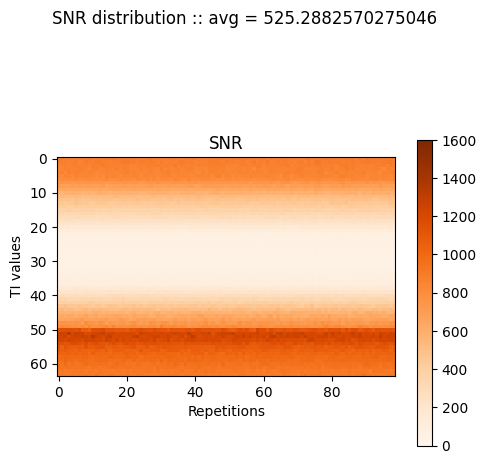

In [127]:
### Evaluate SNR

end_dist = np.std(raw_data[-500:,:,], axis = 0)
max_sig = np.max(np.abs(raw_data), axis = 0)
SNR_mat = max_sig/end_dist

plt.rc('font', size = 10)
fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
fig.suptitle(f"SNR distribution :: avg = {np.mean(SNR_mat)}")
imc1 = ax.imshow(SNR_mat, cmap = 'Oranges', vmin = 0, vmax = np.max(SNR_mat)*1.2)

ax.set_title('SNR')
# ax.set_xticks(np.arange(len(T22_set)))
# ax.set_yticks(np.arange(len(T21_set)))
# ax.set_xticklabels(T22_set)
# ax.set_yticklabels(T21_set)
ax.set_xlabel('Repetitions')
ax.set_ylabel('TI values')
fig.colorbar(imc1, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)

# Surface Shapes

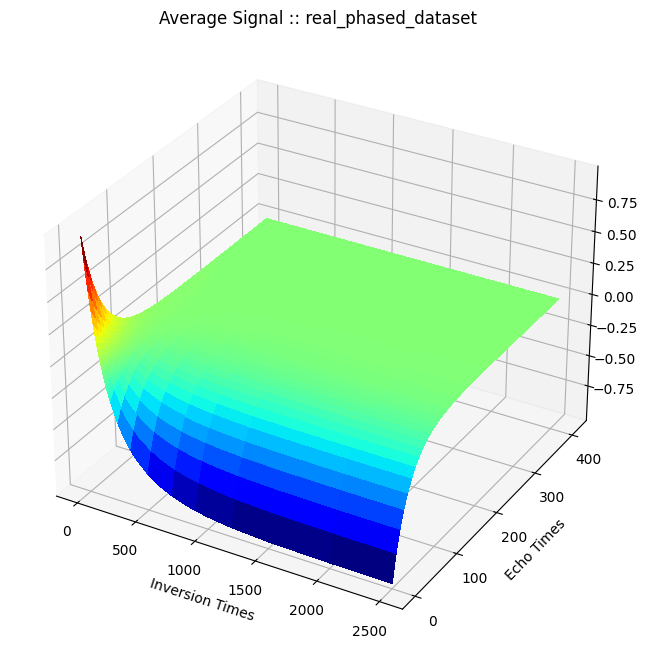

In [128]:
#### Actual Data Surface
mTI, mTE = np.meshgrid(TI_array, TE_sequence, indexing='ij')
average_signal = np.transpose(np.mean(raw_data, axis = 2))

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(mTI, mTE, average_signal, cmap = plt.cm.jet, linewidth=0, antialiased=False)

ax.set_title('Average Signal :: ' + file_oi)
ax.set_xlabel('Inversion Times')
ax.set_ylabel('Echo Times')
plt.show()

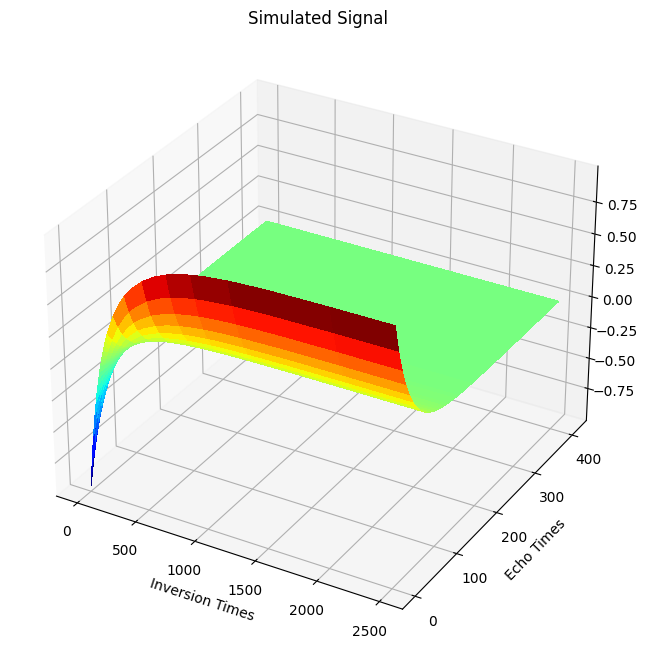

In [129]:
#### Expected Data Surface
mTI, mTE = np.meshgrid(TI_array, TE_sequence, indexing='ij')
signal_mat = S_biX_6p(mTE, mTI, T1low, T1up, 0.5, 0.5, T2low, T2up)

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(mTI, mTE, signal_mat, cmap = plt.cm.jet, linewidth=0, antialiased=False)

ax.set_title('Simulated Signal')
ax.set_xlabel('Inversion Times')
ax.set_ylabel('Echo Times')
plt.show()

# Parameter Fitting

In [130]:
param_array_4p = np.zeros((len(TI_array),noise_realizations,4))
param_array_2p = np.zeros((len(TI_array),noise_realizations,2))
RSS_4p = np.zeros((len(TI_array),noise_realizations))
RSS_2p = np.zeros((len(TI_array),noise_realizations))
std_array_4p = np.zeros((len(TI_array),4))
std_array_2p = np.zeros((len(TI_array),2))
for iTI in trange(len(TI_array)):
    TI_oi = TI_array[iTI]
    data_TI = raw_data[:,iTI,:]
    data_TI_order= np.transpose(data_TI)
    param_array_4p[iTI,:,:], RSS_4p[iTI,:] = estimate_params(TI_oi, TE_sequence, data_TI_order, S_biX_4p)
    param_array_2p[iTI,:,:], RSS_2p[iTI,:] = estimate_params(TI_oi, TE_sequence, data_TI_order, S_moX_2p)
    std_array_4p[iTI,:] = calc_std(param_array_4p[iTI,:,:],[0,1,2,3])
    std_array_2p[iTI,:] = calc_std(param_array_2p[iTI,:,:],[0,1])

100%|██████████| 64/64 [07:33<00:00,  7.08s/it]


# Present Results

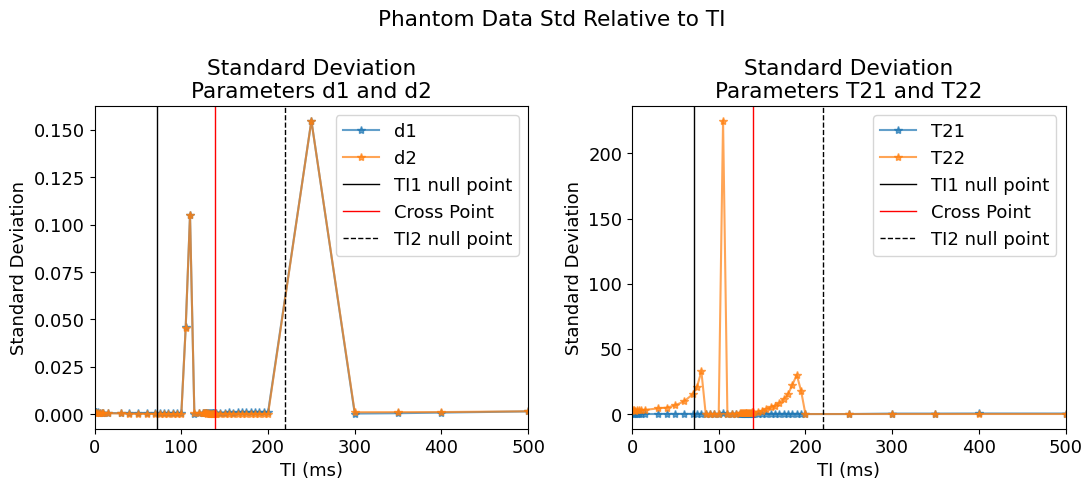

In [131]:
estParams = get_param_list(S_biX_4p)

plt.rc('font', size = 13)
fig, ax = plt.subplots(1,2, figsize=(11,5), tight_layout=True)
fig.suptitle('Phantom Data Std Relative to TI')
for i in range(2):
    ax[i].plot(TI_array, std_array_4p[:,2*i], label = estParams[2*i], alpha = 0.7, marker = '*')
    ax[i].plot(TI_array, std_array_4p[:,2*i+1], label = estParams[2*i+1], alpha = 0.7, marker = '*')
    # ax[i].plot(TI_array,mono_std[:,i], label = MonoTitle[i], alpha = 0.7)
    ax[i].axvline(x=TI1star, linewidth=1, label= r'TI1 null point', color='k')
    ax[i].axvline(x=139, linewidth=1, label= r'Cross Point', color='r')
    ax[i].axvline(x=TI2star, linewidth=1, label= r'TI2 null point', color='k', ls = '--')
    ax[i].set_xlabel('TI (ms)')
    ax[i].set_ylabel('Standard Deviation')
    ax[i].set_title('Standard Deviation' + '\nParameters ' + estParams[2*i] + ' and ' + estParams[2*i+1])
    ax[i].legend()
    ax[i].set_xlim([0,500])
plt.show()

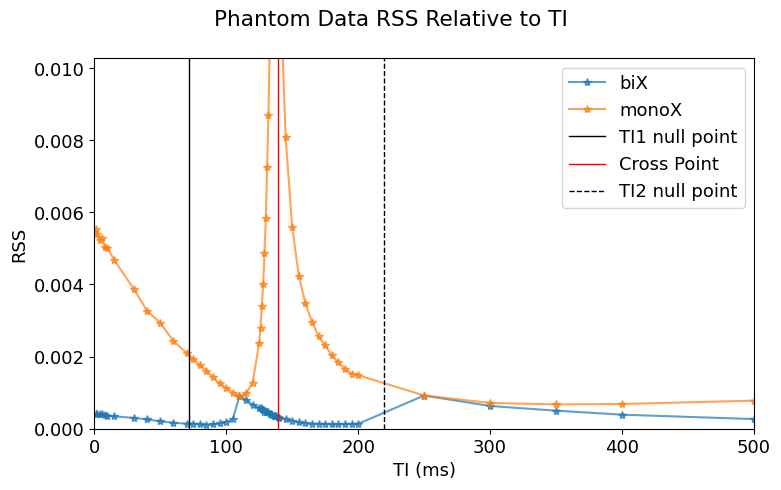

In [132]:
avgRSS_4p = np.mean(RSS_4p, axis = -1)
avgRSS_2p = np.mean(RSS_2p, axis = -1)

plt.rc('font', size = 13)
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)
fig.suptitle('Phantom Data RSS Relative to TI')
for i in range(1):
    ax.plot(TI_array, RSS_4p[:,1], label = "biX", alpha = 0.7, marker = '*')
    ax.plot(TI_array, RSS_2p[:,1], label = "monoX", alpha = 0.7, marker = '*')
    ax.axvline(x=TI1star, linewidth=1, label= r'TI1 null point', color='k')
    ax.axvline(x=139, linewidth=1, label= r'Cross Point', color='r')
    ax.axvline(x=TI2star, linewidth=1, label= r'TI2 null point', color='k', ls = '--')
    ax.set_xlabel('TI (ms)')
    ax.set_ylabel('RSS')
    # ax[i].set_title('' + '\nParameters ' + estParams[2*i] + ' and ' + estParams[2*i+1])
    ax.legend()
    ax.set_xlim([0,500])
    ax.set_ylim([0,np.min([np.min(RSS_4p),np.min(RSS_2p)])*100])
plt.show()

In [2]:
if full_plot:
    for k in range(param_array_4p.shape[0]):
        paramData = param_array_4p[k,:,:].copy()
        fig, ax = plt.subplots(2,2, figsize=(9.5,9.5), tight_layout=True)
        TI = TI_array[k]
        fig.suptitle("Parameter Histogram" + '\n'+ r'$\alpha_1$'+ ' = ' + "{:.3f} :: ".format(TI/TI1star) + r'$\alpha_2$'+ ' = ' + "{:.3f} ".format(TI/TI2star) + ' :: TI = ' + str(round(TI,2)))

        

        true_d1 = d_value(T1low, 0.5*max_sig_mag, TI)
        true_d2 = d_value(T1up, 0.5*max_sig_mag, TI)
        plotParams = (true_d1, true_d2, T2low, T2up)
        
        for ii in range(len(plotParams)):
            #Construct a nice figure of each of the two 
            color_opt = ["b","g"][ii%2]
            ax[ii//2,ii%2].hist(x=paramData[:,ii], bins=10, color=color_opt, label = estParams[ii], alpha = 0.7)
            # ax[ii].hist(x=paramData[:,2*ii+1], bins=20, color='g', label = estParams[2*ii+1], alpha = 0.7)
            ax[ii//2,ii%2].set_xlabel('Param Value')
            ax[ii//2,ii%2].set_ylabel('Count')
            # ax[ii//2,ii%2].axvline(x=plotParams[ii], linewidth=1, label= 'True ' + estParams[ii], color='b')
            # ax[ii].axvline(x=plotParams[2*ii+1], linewidth=1, label= 'True ' + estParams[2*ii+1], color='g')
            ax[ii//2,ii%2].axvline(x=np.mean(paramData[:,ii]), linewidth=1, label= 'Avg ' + estParams[ii], color=color_opt, ls = "--")
            # ax[ii].axvline(x=np.mean(paramData[:,2*ii+1]), linewidth=1, label= 'Avg ' + estParams[2*ii+1], color='g', ls = "--")
            ax[ii//2,ii%2].legend()
            ax[ii//2,ii%2].set_title('Parameter Histogram' +
                        '\nTheroetical True ' + estParams[ii] + '=' + str(round(plotParams[ii],2)))
        plt.show()

In [3]:
if full_plot:
    for k in range(param_array_4p.shape[0]):

        TI = TI_array[k]

        fig, ax = plt.subplots(1,2, figsize=(7,4), tight_layout=True)

        fig.suptitle('Fit Visualization' + '\n' + r'$\alpha_1$'+ ' = ' + "{:.3f} :: ".format(TI/TI1star) + r'$\alpha_2$'+ ' = ' + "{:.3f} ".format(TI/TI2star) + ' :: TI = ' + str(round(TI,2)))
        
        for rep in range(noise_realizations):
            ax[0].plot(TE_sequence, S_biX_4p(TE_sequence, *param_array_4p[k,rep,:]), color='r', alpha = 0.5)
            ax[1].plot(TE_sequence, S_moX_2p(TE_sequence, *param_array_2p[k,rep,:]), color='r', alpha = 0.5)

        ax[0].plot(TE_sequence, average_signal[k,:], label = "True Data", color='k', alpha = 1)
        ax[1].plot(TE_sequence, average_signal[k,:], label = "True Data", color='k', alpha = 1)

        ax[0].set_xlabel("TE")
        ax[1].set_xlabel("TE")
        ax[0].set_ylabel("Signal")
        ax[1].set_ylabel("Signal")
        ax[0].set_title("Biexponential Fits")
        ax[1].set_title("Monoexponential Fits")

        plt.show()

In [135]:
avg_params = np.mean(param_array_4p, axis = -1)

fig.suptitle("Parameter Histogram" + '\n'+ r'$\alpha_1$'+ ' = ' + "{:.3f} :: ".format(TI/TI1star) + r'$\alpha_2$'+ ' = ' + "{:.3f} ".format(TI/TI2star) + ' :: TI = ' + str(round(TI,2)))

true_d1 = d_value(T1low, 0.5*max_sig_mag, TI)
true_d2 = d_value(T1up, 0.5*max_sig_mag, TI)
plotParams = (true_d1, true_d2, T2low, T2up)

for ii in range(len(plotParams)):
    #Construct a nice figure of each of the two 
    color_opt = ["b","g"][ii%2]
    ax[ii//2,ii%2].hist(x=paramData[:,ii], bins=10, color=color_opt, label = estParams[ii], alpha = 0.7)
    # ax[ii].hist(x=paramData[:,2*ii+1], bins=20, color='g', label = estParams[2*ii+1], alpha = 0.7)
    ax[ii//2,ii%2].set_xlabel('Param Value')
    ax[ii//2,ii%2].set_ylabel('Count')
    # ax[ii//2,ii%2].axvline(x=plotParams[ii], linewidth=1, label= 'True ' + estParams[ii], color='b')
    # ax[ii].axvline(x=plotParams[2*ii+1], linewidth=1, label= 'True ' + estParams[2*ii+1], color='g')
    ax[ii//2,ii%2].axvline(x=np.mean(paramData[:,ii]), linewidth=1, label= 'Avg ' + estParams[ii], color=color_opt, ls = "--")
    # ax[ii].axvline(x=np.mean(paramData[:,2*ii+1]), linewidth=1, label= 'Avg ' + estParams[2*ii+1], color='g', ls = "--")
    ax[ii//2,ii%2].legend()
    ax[ii//2,ii%2].set_title('Parameter Histogram' +
                'Theroetical True ' + estParams[ii] + '=' + str(round(plotParams[ii],2)))
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed